# Structural Dynamics Validation

In [307]:
# Amira Abdel-Rahman
# (c) Massachusetts Institute of Technology 2021

# tested using julia 1.5.2 and macbook pro

In [308]:
using FFTW

plotting=true
GPU=false
logging=true
include("../julia/MetaVoxels.jl") #load MetaVoxels!

Loaded MetaVoxels Functions!


---

## Lumped Mass (Old)


### Single DOF in Metavoxels

In [309]:
simName= "tutorial" # set name for simulation
# get a saved setup from an external julia file
# include("../julia/examples/thermalTest.jl") #template for multimaterial hierarchical voxels with different thermal coefficient of thermal expansion 
include("../julia/examples/singleDOF.jl") #template for lattice voxel (big scale with real params)


## recompile these just for sanity check for dynamic loads
include("../julia/MetaVoxels.jl") 

#export setup using nodejs and javascript from "./json/$(simName)Init.json" and save to "./json/$(simName).json"
exportJuliaSettingsUsingNode(setup,simName)

setupSim=getSetup(simName); #get simulation from"./json/$(simName).json"
savedDataFolderPath="../json/$(simName)/" # make sure this folder exists, this is where the simulation result will be saved

setupSimFEA=getSetup(simName);

runMetaVoxels!(setupSim,savedDataFolderPath,"CPU")

Loaded MetaVoxels Functions!
Success! Created structure with 2 nodes and 1 edges.
dt: 0.008595349728956281, s: 0.001, mass: 625.0, momentInertiaInverse: 9600.0
first timestep took 0.96974329 seconds
ran 2 nodes and 1 edges for 2000 time steps took 0.460185933 seconds


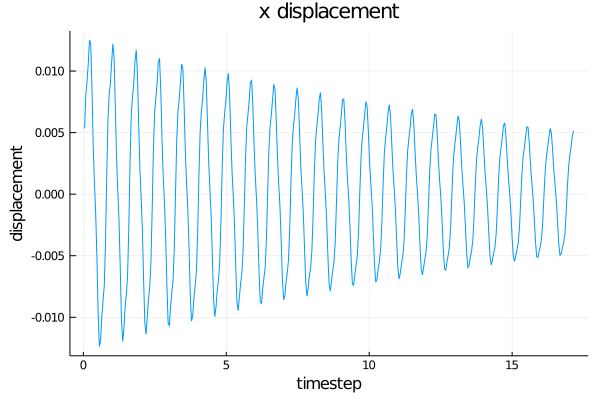

In [310]:
dis=plotDisplacementTroughTimeSteps(simName,2,"x");#setup["globalDamping"]=0.002

### Woked Example

In [311]:
# Constants
m = 10000 # (kg) Mass
xi = 0.02 # Damping ratio
P = 1500 # (N) Static force magnitude
Delta = 7 # (mm) Static displacement

# Undamped natural frequency
k = P/(Delta/1000) #(N/m) Stiffness
omega_n = round(sqrt(k/m),digits=3) #(rads/sec) Angular natural frequency
fn = round(omega_n/(2*pi),digits=3) # (Hz) Natural frequency
T = round(1/fn,digits=2) # (sec) Period of oscillation
c = round(xi*2*m*omega_n,digits=2) #(Ns/m) Damping coefficient
delta = round(2*pi*xi,digits=3) # Logarithmic decrement
omega_d = round(omega_n*sqrt(1-(xi^2)),digits=3) #(rads/sec) Damped angular natural frequency

4.628

In [312]:
u_start = 0.007
u_finish = 0.001
n = log(u_start/u_finish)/delta
n_full = ceil(n)
t_full = T*n_full

tmax = 60 #(sec) The max time
delta_t = 0.01 #(sec) The timestep
nPoints = tmax/delta_t #Number of equally spaced data points

t = LinRange(0,tmax, Int(nPoints)); # Time vector


u = exp.(-xi*omega_n*t).*(0.00014*sin.(omega_d*t) + 0.007 *cos.(omega_d*t)); #The damped oscillation

In [313]:
Plots.plot(t,u,label="Damped oscillation",xlabel="Time (sec)",ylabel="Displacement (m)",title="Displacement-time history")
Plots.plot!([0, tmax],[u_finish,u_finish],linestyle=:dash,lw=0.75,c=:red,label="")
Plots.plot!([t_full, t_full],[u_start,-u_start],linestyle=:dash,lw=0.75,c=:red,label="")


----

## Beam MetaVoxel vs FEM Vibration

In [618]:
simName= "tutorial" # set name for simulation
# get a saved setup from an external julia file

include("../julia/examples/dynamicVal.jl") #template slender beam vibration validation


## recompile these just for sanity check for dynamic loads
include("../julia/MetaVoxels.jl") 

#export setup using nodejs and javascript from "./json/$(simName)Init.json" and save to "./json/$(simName).json"
exportJuliaSettingsUsingNode(setup,simName)

setupSim=getSetup(simName); #get simulation from"./json/$(simName).json"
savedDataFolderPath="../json/$(simName)/" # make sure this folder exists, this is where the simulation result will be saved

setupSimFEA=getSetup(simName);

runMetaVoxels!(setupSim,savedDataFolderPath,"CPU")


Loaded MetaVoxels Functions!
Success! Created structure with 41 nodes and 40 edges.
dt: 3.1483100054946376e-7, s: 0.024999999999999467, mass: 0.00675, momentInertiaInverse: 8.88888888888898e6
first timestep took 1.070483866 seconds
ran 41 nodes and 40 edges for 3000000 time steps took 2317.221062034 seconds


2

1.0

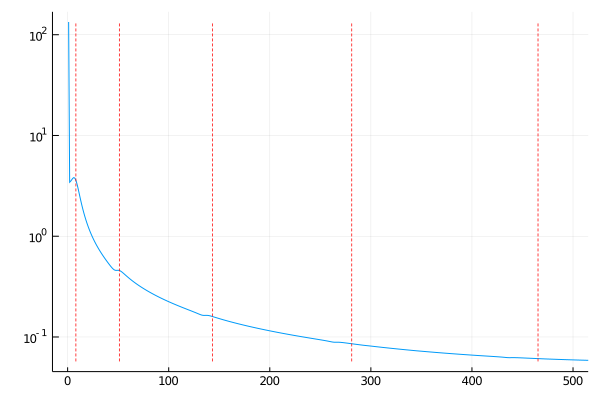

In [619]:
## 40 element with 0.0001 damping 

#get last node
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]==1
        id=i
    end
end
display(id)
# id=2

display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])
disXs=plotDisplacementTroughTimeSteps(simName,id,"x");


# disX=disXs[1:400]
disX=disXs[1:end]

# display(Plots.plot(disX))

maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]


ft=abs.(fft(Float64.(disX .-mean(disX)) ))
ft=abs.(fft(Float64.(disX) ))

# ft=real.(fft(Float64.(disX) ))[1:end]

fmax = 1 / setupSim["dt"]
f = LinRange(0, fmax, length(ft))

Plots.plot(f[1:Int(round(length(disX)/2))],ft[1:Int(round(length(disX)/2))],label="" )
Plots.plot(ft[1:Int(round(length(disX)/2))],label="",xlim=[0,500] )

an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log)
end
display(Plots.plot!())



2

1.0

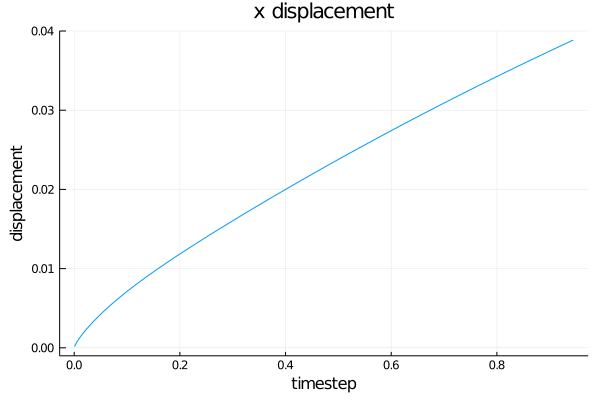

In [617]:
## 40 element with 0.01 damping 

#get last node
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]==1
        id=i
    end
end
display(id)
# id=2

display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])
disXs=plotDisplacementTroughTimeSteps(simName,id,"x");


# disX=disXs[1:400]
disX=disXs[1:end]

# display(Plots.plot(disX))

maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]


ft=abs.(fft(Float64.(disX .-mean(disX)) ))
ft=abs.(fft(Float64.(disX) ))

# ft=real.(fft(Float64.(disX) ))[1:end]

fmax = 1 / setupSim["dt"]
f = LinRange(0, fmax, length(ft))

Plots.plot(f[1:Int(round(length(disX)/2))],ft[1:Int(round(length(disX)/2))],label="" )
Plots.plot(ft[1:Int(round(length(disX)/2))],label="",xlim=[0,500] )

an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log)
end
display(Plots.plot!())



2

1.0

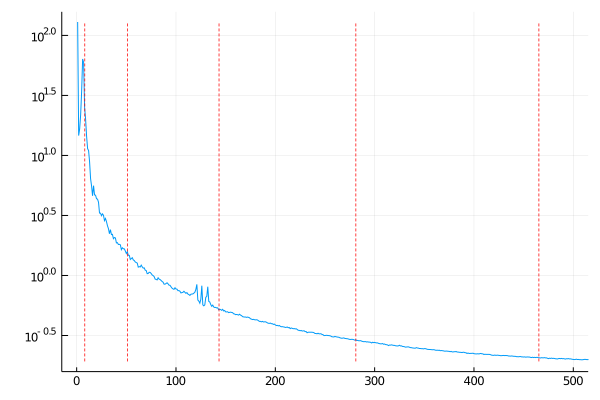

In [610]:
## 1 element

#get last node
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]==1
        id=i
    end
end
display(id)
# id=2

display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])
disXs=plotDisplacementTroughTimeSteps(simName,id,"x");


# disX=disXs[1:400]
disX=disXs[1:end]

# display(Plots.plot(disX))

maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]


ft=abs.(fft(Float64.(disX .-mean(disX)) ))
ft=abs.(fft(Float64.(disX) ))

# ft=real.(fft(Float64.(disX) ))[1:end]

fmax = 1 / setupSim["dt"]
f = LinRange(0, fmax, length(ft))

Plots.plot(f[1:Int(round(length(disX)/2))],ft[1:Int(round(length(disX)/2))],label="" )
Plots.plot(ft[1:Int(round(length(disX)/2))],label="",xlim=[0,500] )

an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log)
end
display(Plots.plot!())



2

1.0

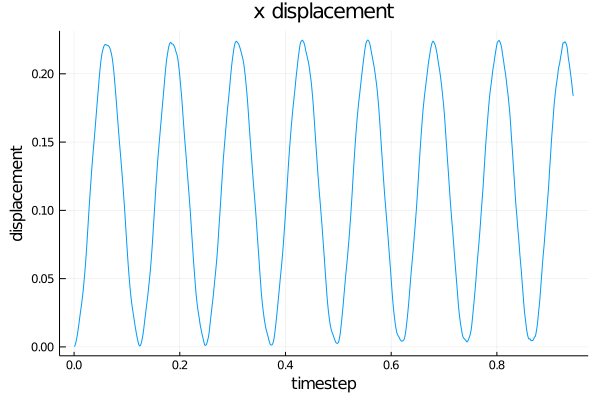

In [606]:
## 5 elements 

#get last node
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]==1
        id=i
    end
end
display(id)
# id=2

display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])
disXs=plotDisplacementTroughTimeSteps(simName,id,"x");


# disX=disXs[1:400]
disX=disXs[1:end]

# display(Plots.plot(disX))

maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]


ft=abs.(fft(Float64.(disX .-mean(disX)) ))
ft=abs.(fft(Float64.(disX) ))

# ft=real.(fft(Float64.(disX) ))[1:end]

fmax = 1 / setupSim["dt"]
f = LinRange(0, fmax, length(ft))

Plots.plot(f[1:Int(round(length(disX)/2))],ft[1:Int(round(length(disX)/2))],label="" )
Plots.plot(ft[1:Int(round(length(disX)/2))],label="",xlim=[0,500] )

an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log)
end
display(Plots.plot!())



In [604]:
## 10 elements 

#get last node
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]==1
        id=i
    end
end
display(id)
# id=2

display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])
disXs=plotDisplacementTroughTimeSteps(simName,id,"x");


# disX=disXs[1:400]
disX=disXs[1:end]

# display(Plots.plot(disX))

maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]


ft=abs.(fft(Float64.(disX .-mean(disX)) ))
ft=abs.(fft(Float64.(disX) ))

# ft=real.(fft(Float64.(disX) ))[1:end]

fmax = 1 / setupSim["dt"]
f = LinRange(0, fmax, length(ft))

Plots.plot(f[1:Int(round(length(disX)/2))],ft[1:Int(round(length(disX)/2))],label="" )
Plots.plot(ft[1:Int(round(length(disX)/2))],label="",xlim=[0,500] )

an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log)
end
display(Plots.plot!())



2

1.0

In [582]:
## 40 elements critical damping or no damping

#get last node
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]==1
        id=i
    end
end
display(id)
# id=1

display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])
disXs=plotDisplacementTroughTimeSteps(simName,id,"x");


# disX=disXs[1:500]
disX=disXs[1:end]

# display(Plots.plot(disX))

maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]


ft=abs.(fft(Float64.(disX .-mean(disX)) ))
ft=abs.(fft(Float64.(disX) ))

# ft=real.(fft(Float64.(disX) ))[1:end]

fmax = 1 / setupSim["dt"]
f = LinRange(0, fmax, length(ft))

Plots.plot(f[1:Int(round(length(disX)/2))],ft[1:Int(round(length(disX)/2))],label="" )
Plots.plot(ft[1:Int(round(length(disX)/2))],label="" )

an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log,xlim=[0,500])
end
display(Plots.plot!())



2

1.0

2

1.0

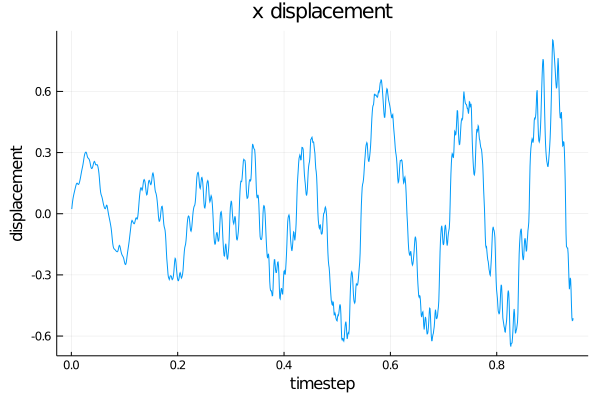

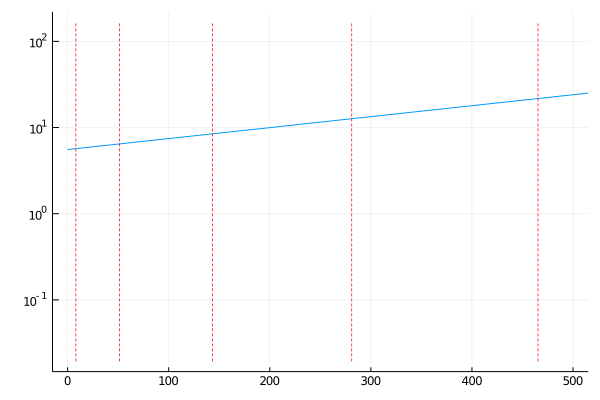

In [565]:
## 4 elements no damping

#get last node
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]==1
        id=i
    end
end
display(id)
# id=1

display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])
disXs=plotDisplacementTroughTimeSteps(simName,id,"x");

disX=disXs[1:500]
disX=disXs[1:end]

maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]


ft=abs.(fft(Float64.(disX .-mean(disX)) ))
ft=abs.(fft(Float64.(disX) ))

# ft=real.(fft(Float64.(disX) ))[1:end]

fmax = 1 / setupSim["dt"]
f = LinRange(0, fmax, length(ft))

Plots.plot(f[1:Int(round(length(disX)/2))],ft[1:Int(round(length(disX)/2))],label="" )

an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log,xlim=[0,500])
end
display(Plots.plot!())



In [504]:
include("../julia/MetaVoxels.jl")
exportJuliaSettingsUsingNode(setup,simName)
setupSimFEA=getSetup(simName);
t=@timed setupSimFEA=solveFea(setupSimFEA);
time=t[2]
println("FEA took $time seconds")

Loaded MetaVoxels Functions!
Success! Created structure with 41 nodes and 40 edges.


120-element Array{Float64,1}:
    505.5426614489184
    505.5426614490469
   1263.8937821495413
   1517.0508061502985
   1517.0508061504222
   2529.8243544721554
   2529.824354472424
   3544.696585505419
   3544.696585505525
   3793.6306783307878
   4562.484880260696
   4562.484880260718
   5583.983527913426
      ⋮
  85359.5997594516
  88861.5385141685
  92278.7735053982
  95570.65977689807
  98691.16251907818
 101589.73262728746
 104212.79494724954
 106505.88440102064
 108416.37187999881
 109896.60291779457
 110907.15031458663
 111419.79079146197

FEA took 0.552572924 seconds


2

1.0

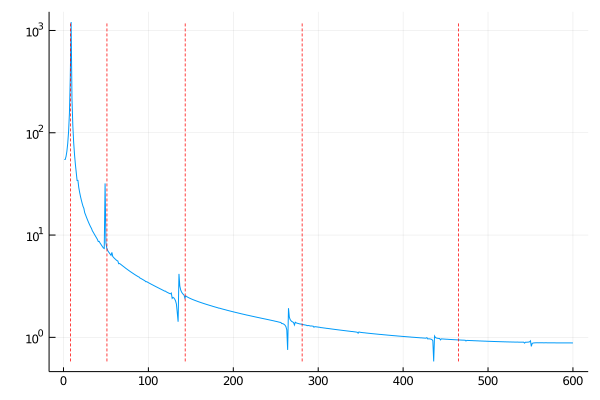

In [499]:
## 40 elements

#get last node
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]==1
        id=i
    end
end
display(id)
# id=1

display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])
disX=plotDisplacementTroughTimeSteps(simName,id,"x");


maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]


ft=abs.(fft(Float64.(disX .-mean(disX)) ))[1:Int(round(length(disX)/2))]
# ft=real.(fft(Float64.(disX) ))[1:end]
ft[1]=ft[2]

Plots.plot(ft,label="" )
an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log)
end
display(Plots.plot!())



In [484]:
function  beam(num_elems)

    #restrained_dofs = [2*(num_elems+1)-1,1] # simply supported
    restrained_dofs = [2,1] # cantilever
    #restrained_dofs = [2*(num_elems+1)-1,2,1] #  built in - pinned beam
    #restrained_dofs = [2*(num_elems+1),2*(num_elems+1)-1,2,1] #  fixed-fixed
    
    l= 1.0 / num_elems
    Cm = 1.0 # rho.A
    Ck= 1.0 #E.I
    
    
    L = 1 #m
    l= L / num_elems
    w = h = 0.01 #m
    A = w*h #m^2
    Iyy = w*h^3/12
    Ixx = w*h^3/12 #m^4
    Izz = 0.01^4/6 #m^4
    E = 6.9e10 #N/m^2
    nu = 0.33
    rho = 2700 #kg/m^3
    m = 2.7 #kg/m
    
    Cm = rho*A
    Ck= E*Ixx
    an2= [3.516, 22.035, 61.697] 
    EI=1
    ML4=1

    EI=Ck
    ML4=Cm
    wn = an2 * sqrt(EI/(ML4))/pi/2
    display("Exat Frequencies $wn")
    
    m = [[156 22*l 54 -13*l];[22*l 4*l*l  13*l -3*l*l];[54 13*l 156 -22*l];[-13*l -3*l*l -22*l 4*l*l]] * Cm * l / 420
    k = [[12 6*l -12 6*l];[6*l 4*l*l -6*l 2*l*l];[-12 -6*l 12 -6*l];[6*l 2*l*l -6*l 4*l*l]] * Ck / l^3
    
    
    M= zeros((2*num_elems+2,2*num_elems+2))
    K= zeros((2*num_elems+2,2*num_elems+2))
    
    
    for i in 1:num_elems
        M_temp= zeros((2*num_elems+2,2*num_elems+2))
        K_temp= zeros((2*num_elems+2,2*num_elems+2))
        
        first_node = 2*(i-1)
        
        M_temp[first_node+1 : first_node+4, first_node+1:first_node+4] = m
        K_temp[first_node+1 : first_node+4, first_node+1:first_node+4] = k


        M +=M_temp
        K +=K_temp
    end
    

    
    for dof in restrained_dofs
        M = M[setdiff(1:end, dof), :]
        K = K[setdiff(1:end, dof), :]

        M = M[:,setdiff(1:end, dof)]
        K = K[:,setdiff(1:end, dof)]

    end

    
    
    evals=eigvals(K,M)
    evecs=eigvecs(K,M)
    frequencies=sqrt.(evals)./pi/2
    
    return M, K, frequencies, evecs
    
end

M, K, frequencies, evecs= beam(10)
K
print(frequencies)

"Exat Frequencies [8.166219296054413, 51.17822587842974, 143.29670987163513]"

[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084, 697.1643855906246, 978.1554629736119, 1310.458670538494, 1694.4067714913876, 2106.3920595628183, 2803.514375083497, 3386.9985635408957, 4105.8297716564175, 4955.46259069976, 5954.718688329792, 7121.889361908151, 8452.57834207649, 9867.982918076517, 11112.443963397101, 13907.09302711687]

---

## Voxel Beam

In [663]:
simName= "tutorial" # set name for simulation
# get a saved setup from an external julia file

include("../julia/examples/voxelDynamics.jl") #template 5 voxel beam


## recompile these just for sanity check for dynamic loads
include("../julia/MetaVoxels.jl") 

#export setup using nodejs and javascript from "./json/$(simName)Init.json" and save to "./json/$(simName).json"
exportJuliaSettingsUsingNode(setup,simName)

setupSim=getSetup(simName); #get simulation from"./json/$(simName).json"
savedDataFolderPath="../json/$(simName)/" # make sure this folder exists, this is where the simulation result will be saved

setupSimFEA=getSetup(simName);

runMetaVoxels!(setupSim,savedDataFolderPath,"CPU")


Loaded MetaVoxels Functions!
Success! Created structure with 44 nodes and 104 edges.
dt: 1.3822195005296e-11, s: 0.053033008588991064, mass: 8.0e-10, momentInertiaInverse: 6.737809981267895e14
first timestep took 1.126964497 seconds


"33.333333333333336%"

"66.66666666666667%"

"100.0%"

"133.33333333333334%"

"166.66666666666669%"

"200.0%"

"233.33333333333331%"

"266.6666666666667%"

"300.0%"

"333.33333333333337%"

"366.66666666666663%"

"400.0%"

"433.33333333333337%"

"466.66666666666663%"

"500.0%"

"533.3333333333334%"

"566.6666666666666%"

"600.0%"

"633.3333333333334%"

"666.6666666666667%"

"700.0%"

"733.3333333333333%"

"766.6666666666667%"

LoadError: [91mTaskFailedException:[39m
[91m[91mInterruptException:[39m[39m
[91mStacktrace:[39m
[91m [1] [1msetFromUnitVectors[22m[1m([22m::Vector3, ::Vector3, ::Int64[1m)[22m at [1m/Users/amiraabdel-rahman/Dropbox (MIT)/CBA/MetaVoxels/metavoxels-code/julia/include/vector.jl:289[22m[39m
[91m [2] [1mtoAxisOriginalQuat[22m[1m([22m::Vector3, ::Vector3, ::Int64[1m)[22m at [1m/Users/amiraabdel-rahman/Dropbox (MIT)/CBA/MetaVoxels/metavoxels-code/julia/include/vector.jl:212[22m[39m
[91m [3] [1mupdateEdges![22m[1m([22m::Int64, ::Int64, ::Float64, ::Int64, ::Array{Int64,1}, ::Array{Int64,1}, ::Array{Int64,1}, ::Array{Int64,1}, ::Array{Float64,1}, ::Array{Vector3,1}, ::Array{Float64,1}, ::Array{Vector3,1}, ::Array{Vector3,1}, ::Array{Vector3,1}, ::Array{Quaternion,1}, ::Array{Quaternion,1}, ::Array{Vector3,1}, ::Array{Vector3,1}, ::Array{Vector3,1}, ::Array{Vector3,1}, ::Array{Bool,1}, ::Array{Bool,1}, ::Array{edgeMaterial,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Vector3,1}, ::Array{Quaternion,1}, ::Array{Vector3,1}[1m)[22m at [1m/Users/amiraabdel-rahman/Dropbox (MIT)/CBA/MetaVoxels/metavoxels-code/julia/include/updateEdges.jl:216[22m[39m
[91m [4] [1mmacro expansion[22m at [1m/Users/amiraabdel-rahman/Dropbox (MIT)/CBA/MetaVoxels/metavoxels-code/julia/include/updateEdges.jl:288[22m [inlined][39m
[91m [5] [1m(::var"#88549#threadsfor_fun#3683"{Float64,Int64,Array{Int64,1},Array{Int64,1},Array{Int64,1},Array{Int64,1},Array{Float64,1},Array{Vector3,1},Array{Float64,1},Array{Vector3,1},Array{Vector3,1},Array{Vector3,1},Array{Quaternion,1},Array{Quaternion,1},Array{Vector3,1},Array{Vector3,1},Array{Vector3,1},Array{Vector3,1},Array{Bool,1},Array{Bool,1},Array{edgeMaterial,1},Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Vector3,1},Array{Quaternion,1},Array{Vector3,1},UnitRange{Int64}})[22m[1m([22m::Bool[1m)[22m at [1m./threadingconstructs.jl:81[22m[39m
[91m [6] [1m(::var"#88549#threadsfor_fun#3683"{Float64,Int64,Array{Int64,1},Array{Int64,1},Array{Int64,1},Array{Int64,1},Array{Float64,1},Array{Vector3,1},Array{Float64,1},Array{Vector3,1},Array{Vector3,1},Array{Vector3,1},Array{Quaternion,1},Array{Quaternion,1},Array{Vector3,1},Array{Vector3,1},Array{Vector3,1},Array{Vector3,1},Array{Bool,1},Array{Bool,1},Array{edgeMaterial,1},Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Float64,1},Array{Vector3,1},Array{Quaternion,1},Array{Vector3,1},UnitRange{Int64}})[22m[1m([22m[1m)[22m at [1m./threadingconstructs.jl:48[22m[39m

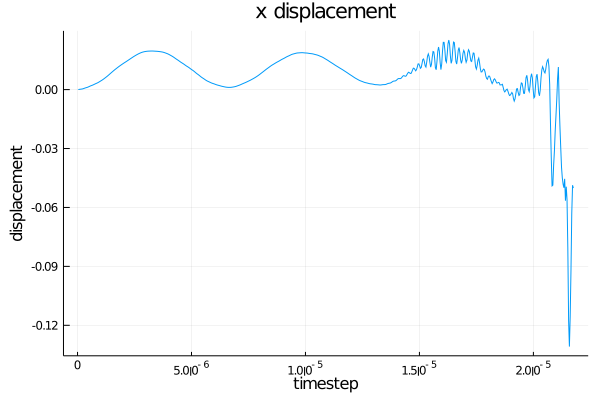

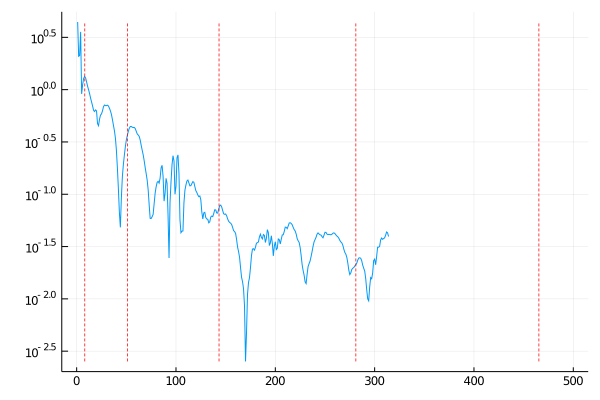

Loaded MetaVoxels Functions!


GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [664]:
include("../julia/MetaVoxels.jl") 
#get last node
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]>=setupSim["voxelSize"]*5 && node["position"]["x"]/setupSim["scale"]>=setupSim["voxelSize"]*1 
        id=i
    end
end
# display(id)
# # id=2
# display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])
skip=570
# skip=0
disXs=plotDisplacementTroughTimeSteps(simName,id,"x",skip);


# disX=disXs[1:650]
disX=disXs[1:end]



maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]

# display(Plots.plot(disX))


ft=abs.(fft(Float64.(disX .-mean(disX)) ))
ft=abs.(fft(Float64.(disX) ))

# ft=real.(fft(Float64.(disX) ))[1:end]

fmax = 1 / setupSim["dt"]
f = LinRange(0, fmax, length(ft))

Plots.plot(f[1:Int(round(length(disX)/2))],ft[1:Int(round(length(disX)/2))],label="" )
Plots.plot(ft[1:Int(round(length(disX)/2))],label="",xlim=[0,500] )

an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log)
end
display(Plots.plot!())



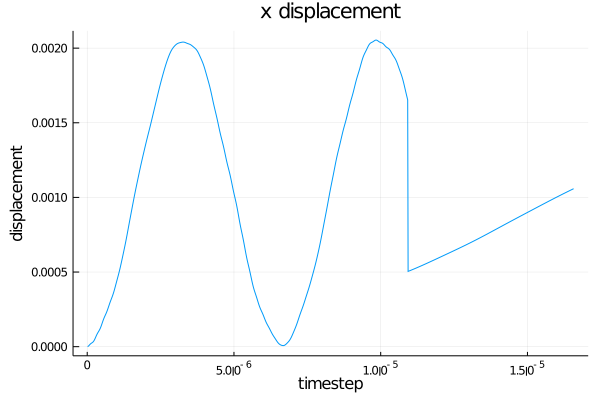

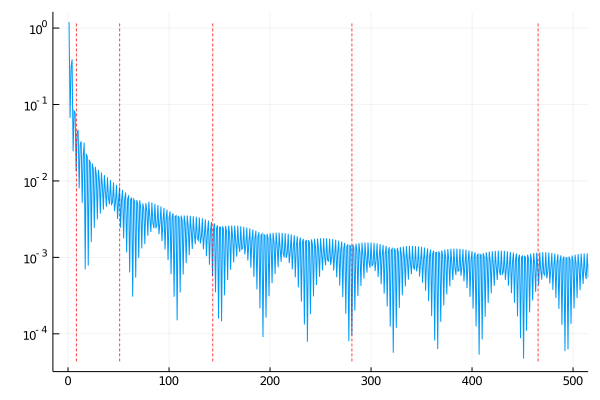

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error


In [638]:
#get last node # four times bigger dt and /10 timesteps
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]>=setupSim["voxelSize"]*5 && node["position"]["x"]/setupSim["scale"]>=setupSim["voxelSize"]*1 
        id=i
    end
end
# display(id)
# # id=2
# display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])

disXs=plotDisplacementTroughTimeSteps(simName,id,"x");


# disX=disXs[1:400]
disX=disXs[1:end]

# display(Plots.plot(disX))

maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]


ft=abs.(fft(Float64.(disX .-mean(disX)) ))
ft=abs.(fft(Float64.(disX) ))

# ft=real.(fft(Float64.(disX) ))[1:end]

fmax = 1 / setupSim["dt"]
f = LinRange(0, fmax, length(ft))

Plots.plot(f[1:Int(round(length(disX)/2))],ft[1:Int(round(length(disX)/2))],label="" )
Plots.plot(ft[1:Int(round(length(disX)/2))],label="",xlim=[0,500] )

an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log)
end
display(Plots.plot!())



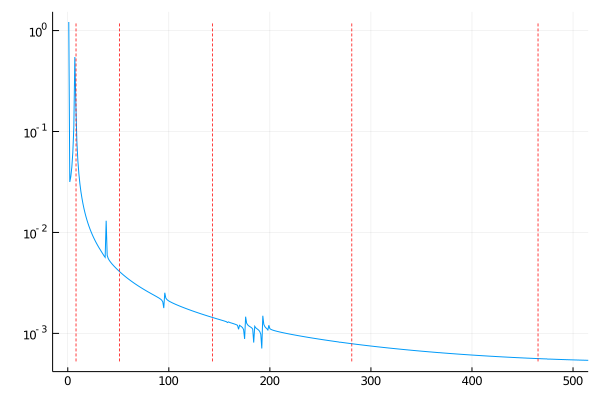

GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to unicode error
GKS: character ignored due to un

In [630]:
#get last node
id=1
for (i,node) in enumerate(setupSim["nodes"])
    if node["position"]["y"]/setupSim["scale"]>=setupSim["voxelSize"]*5 && node["position"]["x"]/setupSim["scale"]>=setupSim["voxelSize"]*1 
        id=i
    end
end
# display(id)
# # id=2
# display(setupSim["nodes"][id]["position"]["y"]/setupSim["scale"])

disXs=plotDisplacementTroughTimeSteps(simName,id,"x");


# disX=disXs[1:400]
disX=disXs[1:end]

# display(Plots.plot(disX))

maxNumFiles=setupSim["maxNumFiles"]
numTimeSteps=setupSim["numTimeSteps"]
x=(1:maxNumFiles).*floor(numTimeSteps/maxNumFiles)
x=x.*setupSim["dt"]


ft=abs.(fft(Float64.(disX .-mean(disX)) ))
ft=abs.(fft(Float64.(disX) ))

# ft=real.(fft(Float64.(disX) ))[1:end]

fmax = 1 / setupSim["dt"]
f = LinRange(0, fmax, length(ft))

Plots.plot(f[1:Int(round(length(disX)/2))],ft[1:Int(round(length(disX)/2))],label="" )
Plots.plot(ft[1:Int(round(length(disX)/2))],label="",xlim=[0,500] )

an = [8.17, 51.2, 143]
an=[8.166261741813996, 51.178738868739394, 143.33369238238393, 281.0729303113941, 465.3614573477084]#, 697.1643855906246, 978.1554629736119]
for a in an
    Plots.plot!([a, a],[minimum(ft),maximum(ft)],linestyle=:dash,lw=0.75,c=:red,label="", yaxis=:log)
end
display(Plots.plot!())

